In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from statsmodels.regression.linear_model import OLS

In [4]:
data = pd.read_csv('../data/prcp_monthly.csv')
data['month'] = pd.to_datetime(data['month'])
data.columns = ['index', 'month', 'prcp']
data.head()

,index,month,prcp
0,0,2001-01-01,101.4
1,1,2001-02-01,98.2
2,2,2001-03-01,201.2
3,3,2001-04-01,141.2
4,4,2001-05-01,33.3


## 1. Quarterly seasonality:

##### Quarterly data:

In [5]:
s1 = np.zeros(len(data))
s2 = np.zeros(len(data))
s3 = np.zeros(len(data))
s4 = np.zeros(len(data))

s1[(data['month'].dt.month >= 1) & (data['month'].dt.month <= 3)] = 1
s2[(data['month'].dt.month >= 4) & (data['month'].dt.month <= 6)] = 1
s3[(data['month'].dt.month >= 7) & (data['month'].dt.month <= 9)] = 1
s4[(data['month'].dt.month >= 10) & (data['month'].dt.month <= 12)] = 1

seasonal_data = data.copy()
seasonal_data['s1'] = s1
seasonal_data['s2'] = s2
seasonal_data['s3'] = s3
seasonal_data['s4'] = s4
seasonal_data['index2'] = seasonal_data['index']**2
seasonal_data['index3'] = seasonal_data['index']**3
seasonal_data.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')

seasonal_data.head()

,index,month,prcp,s1,s2,s3,s4,index2,index3
2001-01-31,0,2001-01-01,101.4,1.0,0.0,0.0,0.0,0,0
2001-02-28,1,2001-02-01,98.2,1.0,0.0,0.0,0.0,1,1
2001-03-31,2,2001-03-01,201.2,1.0,0.0,0.0,0.0,4,8
2001-04-30,3,2001-04-01,141.2,0.0,1.0,0.0,0.0,9,27
2001-05-31,4,2001-05-01,33.3,0.0,1.0,0.0,0.0,16,64


##### Train test split:

In [6]:
seasonal_train = seasonal_data[seasonal_data['month'].dt.year <= 2015]
seasonal_test = seasonal_data[seasonal_data['month'].dt.year > 2015]

#### Linear model:

`y_t = b_0*t + b_1*S_1 + b_2*S_2 + b_3*S_3 + b_4*S_4`

In [7]:
linear = OLS(seasonal_train['prcp'], seasonal_train[['index', 's1', 's2', 's3', 's4']]).fit()
linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prcp   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     113.5
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           1.52e-47
Time:                        00:34:56   Log-Likelihood:                -944.89
No. Observations:                 180   AIC:                             1900.
Df Residuals:                     175   BIC:                             1916.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.0250      0.067      0.371      0.711      -0.108       0.158
s1           205.3607      9.009     22.796      0.000     187.581     223.140
s2            57.5843      9.138      6.302      0.000      39.550      75.619
s3            27.2129      9.269      2.936      0.004       8.919      45.507
s4           168.6816      9.404     17.938      0.000     150.123     187.241
==============================================================================
Omnibus:                        4.247   Durbin-Watson:                   1.867
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                3.796
Skew:                           0.319   Prob(JB):                        0.150
Kurtosis:                       3.314   Cond. No.                         413.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Biến `t` không có nhiều ý nghĩa thống kê trong mô hình do p-value < 0.05

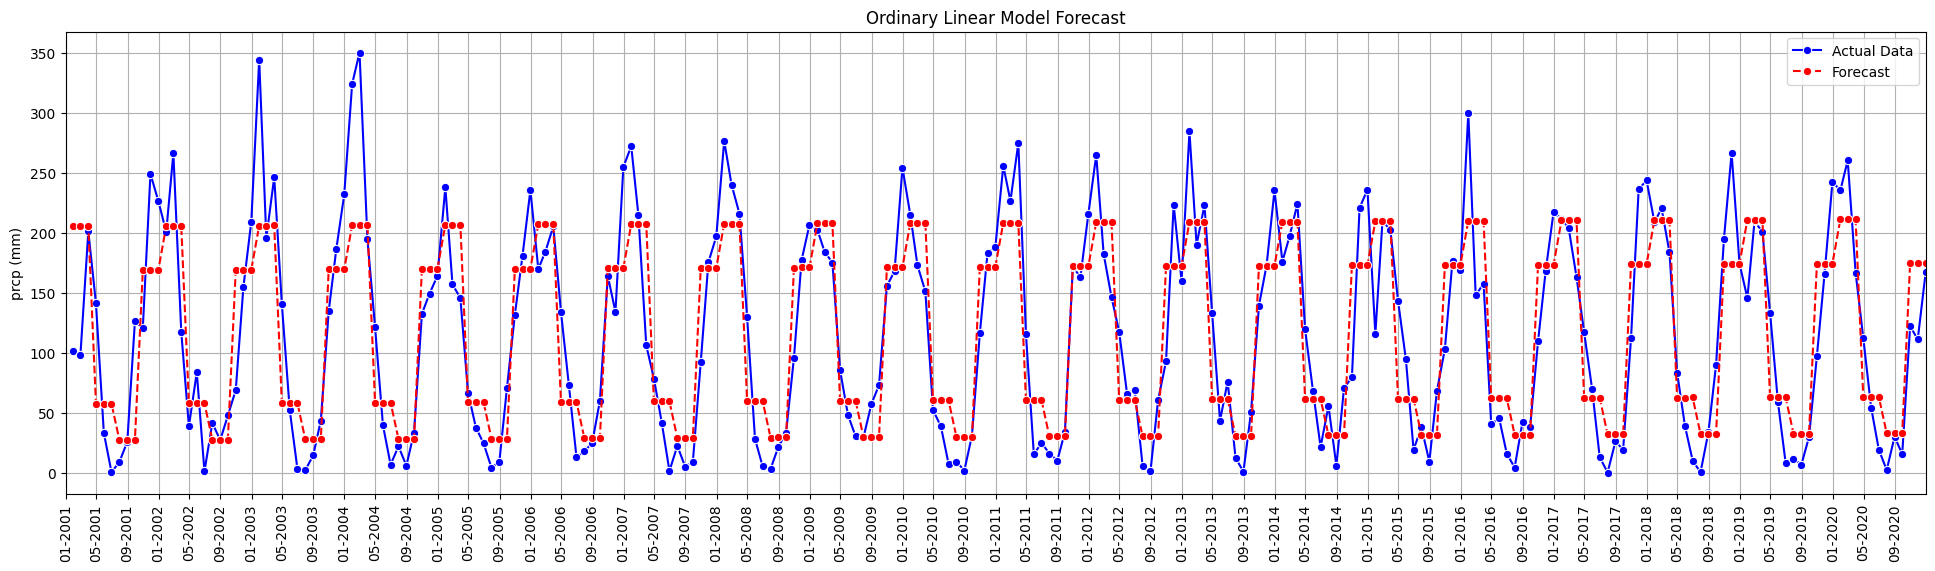

In [8]:
output = linear.predict(seasonal_data[['index', 's1', 's2', 's3', 's4']])
output_copy = pd.Series(output, index=pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME'))

plt.figure(figsize=(24, 6))
sns.lineplot(seasonal_data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(output_copy, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Ordinary Linear Model Forecast")
plt.legend()
# plt.savefig('../forecast/quaterly_ordinary_linear_model.png')
plt.show()

Evaluate:

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(seasonal_test['prcp'], output[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(seasonal_test['prcp'], output[-60:])
r2 = r2_score(seasonal_test['prcp'], output[-60:])
aic = linear.aic
bic = linear.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")


MSE: 1756.59
RMSE: 41.91
MAE: 33.34
R²: 0.764
AIC: 1899.79
BIC: 1915.75


### Quadratic model:

`y_t = b_0*t + b_1*t^2 + b_1*S_1 + b_2*S_2 + b_3*S_3 + b_4*S_4`

In [10]:
linear2 = OLS(seasonal_train['prcp'], seasonal_train[['index', 'index2', 's1', 's2', 's3', 's4']]).fit()
linear2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prcp   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.714
Method:                 Least Squares   F-statistic:                     90.32
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           1.72e-46
Time:                        00:38:06   Log-Likelihood:                -944.89
No. Observations:                 180   AIC:                             1902.
Df Residuals:                     174   BIC:                             1921.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.0029      0.268      0.011      0.991      -0.525       0.531
index2         0.0001      0.001      0.085      0.932      -0.003       0.003
s1           206.0148     11.851     17.384      0.000     182.625     229.405
s2            58.2406     11.967      4.867      0.000      34.622      81.859
s3            27.8692     12.068      2.309      0.022       4.051      51.688
s4           169.3357     12.155     13.931      0.000     145.345     193.327
==============================================================================
Omnibus:                        4.159   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.125   Jarque-Bera (JB):                3.707
Skew:                           0.314   Prob(JB):                        0.157
Kurtosis:                       3.318   Cond. No.                     8.55e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Biến `t`, `t^2`, `s3` không có nhiều ý nghĩa thống kê trong mô hình do p-value < 0.05

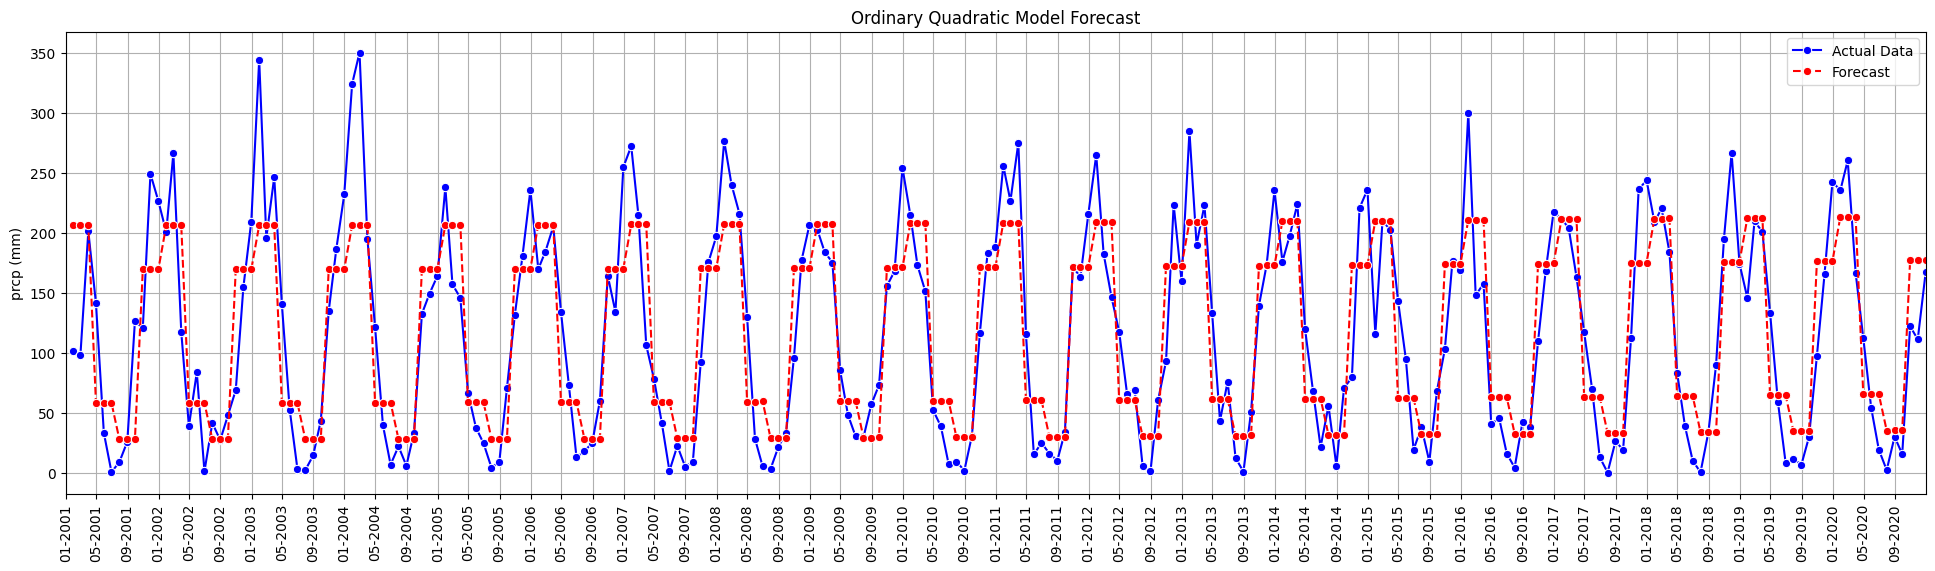

In [11]:
output2 = linear2.predict(seasonal_data[['index', 'index2', 's1', 's2', 's3', 's4']])
output2_copy = pd.Series(output2, index=pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME'))

plt.figure(figsize=(24, 6))
sns.lineplot(seasonal_data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(output2_copy, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Ordinary Quadratic Model Forecast")
plt.legend()
# plt.savefig('../forecast/quarterly_ordinary_quadratic_model.png')
plt.show()

Evaluate:

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(seasonal_test['prcp'], output2[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(seasonal_test['prcp'], output2[-60:])
r2 = r2_score(seasonal_test['prcp'], output2[-60:])
aic = linear2.aic
bic = linear2.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 1779.10
RMSE: 42.18
MAE: 33.89
R²: 0.761
AIC: 1901.78
BIC: 1920.94


### Cubic model:

In [13]:
linear3 = OLS(seasonal_train['prcp'], seasonal_train[['index', 'index2', 'index3', 's1', 's2', 's3', 's4']]).fit()
linear3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prcp   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     74.99
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           1.52e-45
Time:                        00:38:43   Log-Likelihood:                -944.75
No. Observations:                 180   AIC:                             1904.
Df Residuals:                     173   BIC:                             1926.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.3161      0.669      0.473      0.637      -1.004       1.636
index2        -0.0043      0.009     -0.490      0.625      -0.021       0.013
index3      1.633e-05   3.19e-05      0.511      0.610   -4.67e-05    7.93e-05
s1           201.6293     14.649     13.764      0.000     172.716     230.543
s2            53.6959     14.926      3.597      0.000      24.235      83.157
s3            23.1667     15.193      1.525      0.129      -6.820      53.154
s4           164.4740     15.452     10.644      0.000     133.975     194.973
==============================================================================
Omnibus:                        4.015   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.134   Jarque-Bera (JB):                3.569
Skew:                           0.318   Prob(JB):                        0.168
Kurtosis:                       3.269   Cond. No.                     1.72e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.72e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

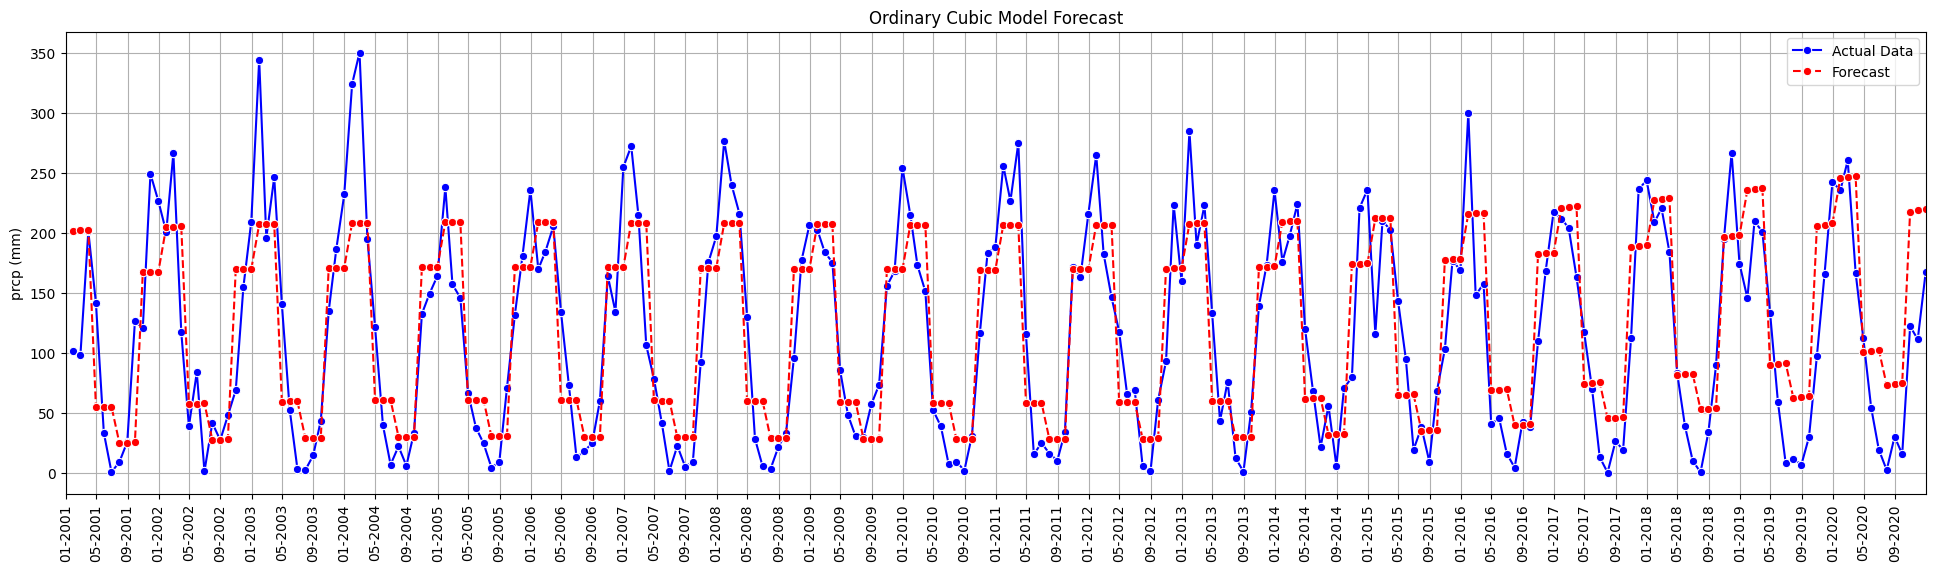

In [14]:
output3 = linear3.predict(seasonal_data[['index', 'index2', 'index3','s1', 's2', 's3', 's4']])
output3_copy = pd.Series(output3, index=pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME'))

plt.figure(figsize=(24, 6))
sns.lineplot(seasonal_data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(output3_copy, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Ordinary Cubic Model Forecast")
plt.legend()
# plt.savefig('../forecast/quarterly_ordinary_cubic_model.png')
plt.show()

Evaluate:

In [15]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(seasonal_test['prcp'], output3[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(seasonal_test['prcp'], output3[-60:])
r2 = r2_score(seasonal_test['prcp'], output3[-60:])
aic = linear3.aic
bic = linear3.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 2696.10
RMSE: 51.92
MAE: 44.10
R²: 0.638
AIC: 1903.51
BIC: 1925.86


## 2. Monthly seasonality:

##### Monthly data:

In [16]:
dummy_months = [np.zeros(len(data)) for i in range(12)]

for i in range(12):
    dummy_months[i][(data['month'].dt.month == i+1)] = 1

monthly_data = data.copy()
for i in range(12):
    monthly_data[f'm{i+1}'] = dummy_months[i]
monthly_data['index2'] = monthly_data['index']**2
monthly_data['index3'] = monthly_data['index']**3
monthly_data.index = pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME')

monthly_data.head()

,index,month,prcp,m1,m2,m3,m4,m5,m6,m7,m8,m9,m10,m11,m12,index2,index3
2001-01-31,0,2001-01-01,101.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2001-02-28,1,2001-02-01,98.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2001-03-31,2,2001-03-01,201.2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,8
2001-04-30,3,2001-04-01,141.2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,27
2001-05-31,4,2001-05-01,33.3,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,64


In [17]:
monthly_train = monthly_data[monthly_data['month'].dt.year <= 2015]
monthly_test = monthly_data[monthly_data['month'].dt.year > 2015]

##### Linear model:

In [18]:
features = ['index', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']
linear1 = OLS(monthly_train['prcp'], monthly_train[features]).fit()
linear1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prcp   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     69.08
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           2.85e-58
Time:                        00:39:52   Log-Likelihood:                -899.34
No. Observations:                 180   AIC:                             1825.
Df Residuals:                     167   BIC:                             1866.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.0250      0.053      0.468      0.640      -0.080       0.130
m1           227.1931     10.588     21.457      0.000     206.289     248.097
m2           202.4517     10.611     19.079      0.000     181.502     223.401
m3           186.4276     10.634     17.531      0.000     165.433     207.422
m4           105.7418     10.657      9.922      0.000      84.701     126.782
m5            48.7889     10.681      4.568      0.000      27.702      69.875
m6            18.2121     10.704      1.701      0.091      -2.921      39.345
m7            17.1372     10.728      1.597      0.112      -4.043      38.317
m8            12.5509     10.752      1.167      0.245      -8.677      33.778
m9            51.9403     10.776      4.820      0.000      30.665      73.216
m10          117.5740     10.801     10.886      0.000      96.250     138.898
m11          178.6264     10.825     16.501      0.000     157.254     199.999
m12          209.8338     10.850     19.339      0.000     188.412     231.255
==============================================================================
Omnibus:                       16.747   Durbin-Watson:                   1.629
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               54.352
Skew:                           0.161   Prob(JB):                     1.58e-12
Kurtosis:                       5.673   Cond. No.                         716.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- Biến `t` không có nhiều ý nghĩa trong mô hình do `p-value` < 0.05

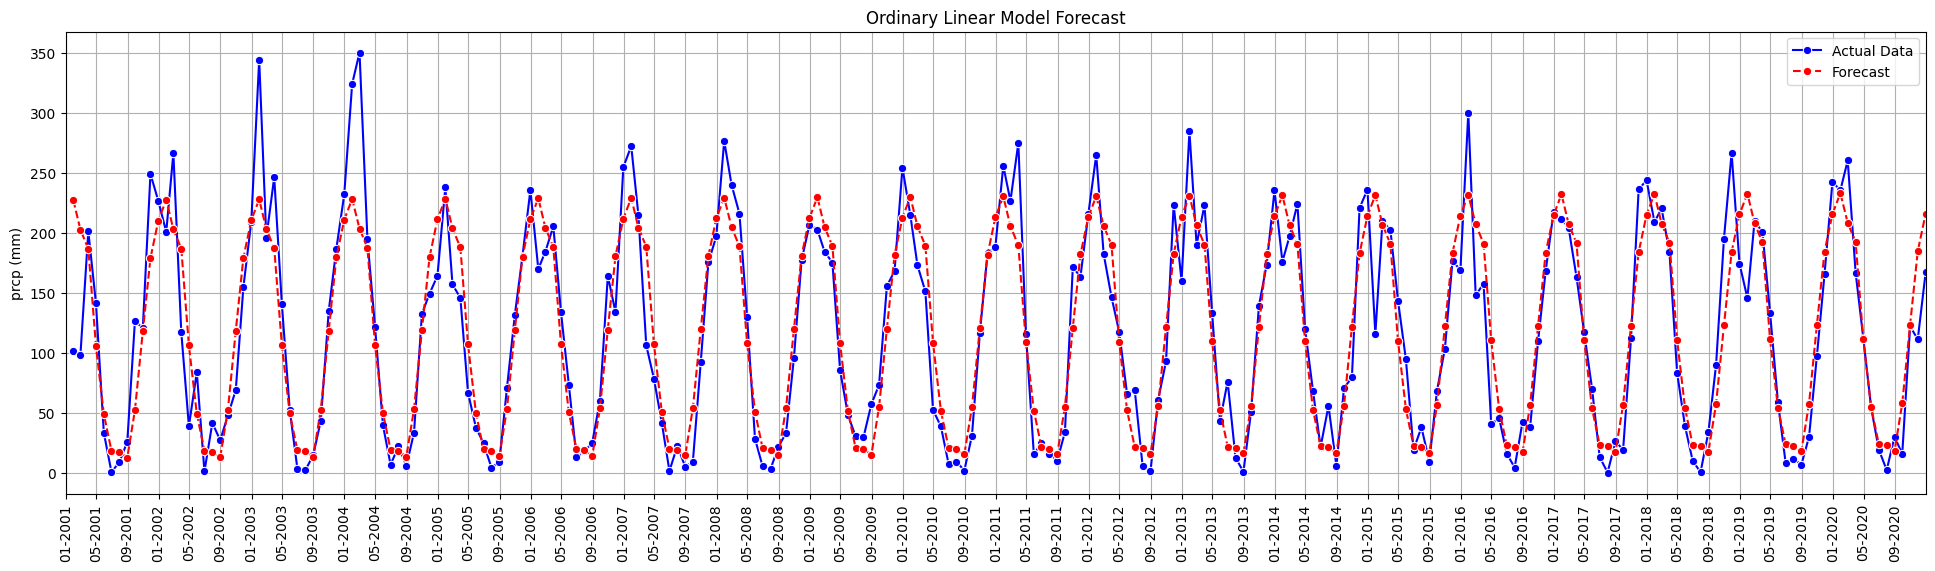

In [19]:
output = linear1.predict(monthly_data[features])
output_copy = pd.Series(output, index=pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME'))

plt.figure(figsize=(24, 6))
sns.lineplot(monthly_data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(output_copy, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Ordinary Linear Model Forecast")
plt.legend()
# plt.savefig('../forecast/monthly_ordinary_cubic_model.png')
plt.show()

Evaluate:

In [20]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(monthly_test['prcp'], output[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(monthly_test['prcp'], output[-60:])
r2 = r2_score(monthly_test['prcp'], output[-60:])
aic = linear1.aic
bic = linear1.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 1087.24
RMSE: 32.97
MAE: 24.86
R²: 0.854
AIC: 1824.68
BIC: 1866.19


##### Quadratic model:

In [21]:
features = ['index', 'index2', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']
linear2 = OLS(monthly_train['prcp'], monthly_train[features]).fit()
linear2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prcp   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     63.39
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           2.42e-57
Time:                        00:43:07   Log-Likelihood:                -899.34
No. Observations:                 180   AIC:                             1827.
Df Residuals:                     166   BIC:                             1871.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.0070      0.213      0.033      0.974      -0.413       0.427
index2         0.0001      0.001      0.088      0.930      -0.002       0.002
m1           227.7265     12.240     18.605      0.000     203.560     251.893
m2           202.9861     12.266     16.549      0.000     178.769     227.203
m3           186.9628     12.290     15.212      0.000     162.697     211.228
m4           106.2776     12.314      8.631      0.000      81.966     130.590
m5            49.3251     12.337      3.998      0.000      24.968      73.682
m6            18.7485     12.358      1.517      0.131      -5.651      43.148
m7            17.6736     12.379      1.428      0.155      -6.767      42.114
m8            13.0871     12.399      1.056      0.293     -11.393      37.567
m9            52.4761     12.418      4.226      0.000      27.959      76.993
m10          118.1092     12.436      9.498      0.000      93.557     142.662
m11          179.1608     12.453     14.387      0.000     154.575     203.747
m12          210.3671     12.469     16.871      0.000     185.749     234.985
==============================================================================
Omnibus:                       16.795   Durbin-Watson:                   1.629
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               55.185
Skew:                           0.153   Prob(JB):                     1.04e-12
Kurtosis:                       5.695   Cond. No.                     1.48e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Nhiều biến không có ý nghĩa

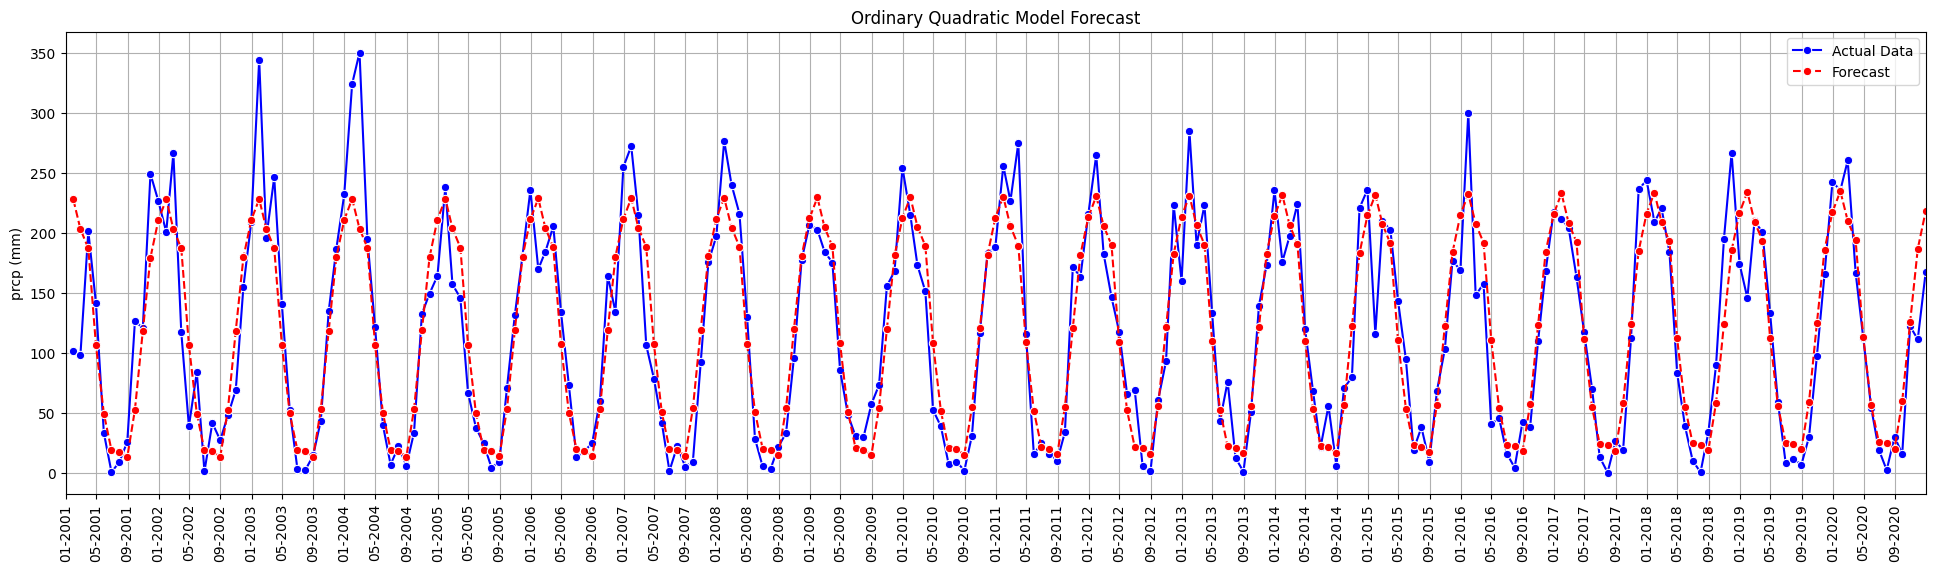

In [22]:
output2 = linear2.predict(monthly_data[features])
output2_copy = pd.Series(output2, index=pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME'))

plt.figure(figsize=(24, 6))
sns.lineplot(monthly_data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(output2_copy, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Ordinary Quadratic Model Forecast")
plt.legend()
# plt.savefig('../forecast/monthly_ordinary_quadratic_model.png')
plt.show()

Evaluate:

In [23]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(monthly_test['prcp'], output2[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(monthly_test['prcp'], output2[-60:])
r2 = r2_score(monthly_test['prcp'], output2[-60:])
aic = linear2.aic
bic = linear2.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 1105.29
RMSE: 33.25
MAE: 25.19
R²: 0.852
AIC: 1826.67
BIC: 1871.37


##### Cubic model:

In [24]:
features = ['index', 'index2', 'index3', 'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']
linear3 = OLS(monthly_train['prcp'], monthly_train[features]).fit()
linear3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   prcp   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.819
Method:                 Least Squares   F-statistic:                     58.68
Date:                Wed, 05 Mar 2025   Prob (F-statistic):           1.60e-56
Time:                        00:43:25   Log-Likelihood:                -899.11
No. Observations:                 180   AIC:                             1828.
Df Residuals:                     165   BIC:                             1876.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
index          0.3206      0.531      0.603      0.547      -0.729       1.370
index2        -0.0043      0.007     -0.621      0.536      -0.018       0.009
index3      1.635e-05   2.54e-05      0.644      0.520   -3.38e-05    6.65e-05
m1           223.3884     13.990     15.968      0.000     195.767     251.010
m2           198.5942     14.052     14.132      0.000     170.849     226.340
m3           182.5175     14.114     12.931      0.000     154.650     210.385
m4           101.7792     14.175      7.180      0.000      73.791     129.768
m5            44.7739     14.236      3.145      0.002      16.667      72.881
m6            14.1446     14.295      0.989      0.324     -14.080      42.370
m7            13.0171     14.354      0.907      0.366     -15.324      41.359
m8             8.3779     14.413      0.581      0.562     -20.079      36.835
m9            47.7142     14.471      3.297      0.001      19.143      76.286
m10          113.2942     14.528      7.798      0.000      84.609     141.979
m11          174.2924     14.586     11.950      0.000     145.494     203.091
m12          205.4449     14.643     14.030      0.000     176.533     234.357
==============================================================================
Omnibus:                       16.040   Durbin-Watson:                   1.632
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               49.197
Skew:                           0.169   Prob(JB):                     2.08e-11
Kurtosis:                       5.539   Cond. No.                     2.98e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.98e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

- Nhiều biến không mang ý nghĩa trong mô hình

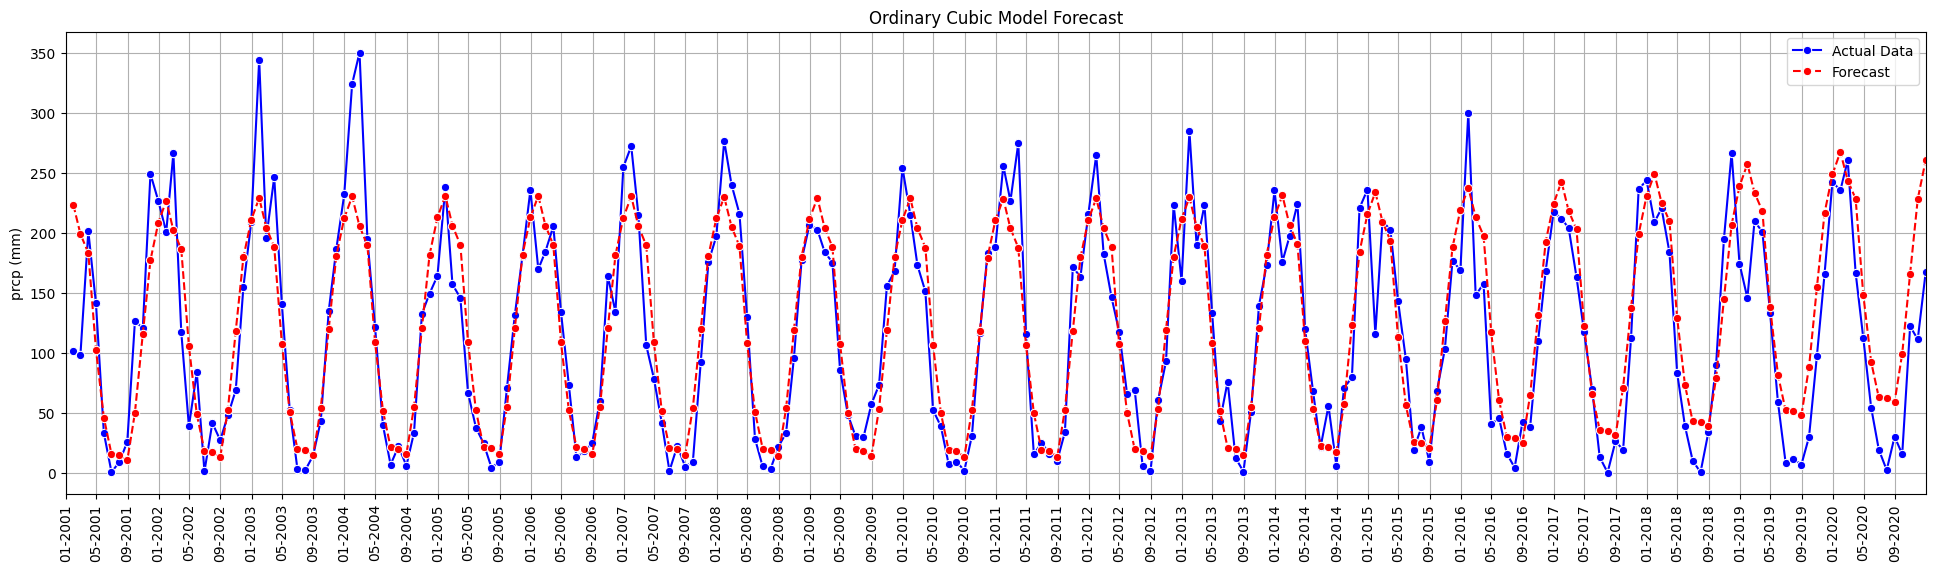

In [25]:
output3 = linear3.predict(monthly_data[features])
output3_copy = pd.Series(output3, index=pd.date_range(start='2001-01-01', end='2020-12-31', freq='ME'))

plt.figure(figsize=(24, 6))
sns.lineplot(monthly_data["prcp"], label="Actual Data", color="blue", marker="o")
sns.lineplot(output3_copy, label="Forecast", color="red", linestyle="dashed", marker='o')
plt.xlim(pd.to_datetime("2001-01-01"), pd.to_datetime("2020-12-31"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=4)) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
plt.xticks(rotation=90)  
plt.grid(True)
plt.ylabel("prcp (mm)")
plt.title("Ordinary Cubic Model Forecast")
plt.legend()
# plt.savefig('../forecast/monthly_ordinary_cubic_model.png')
plt.show()

Evaluate:

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(monthly_test['prcp'], output3[-60:])
rmse = mse ** 0.5
mae = mean_absolute_error(monthly_test['prcp'], output3[-60:])
r2 = r2_score(monthly_test['prcp'], output3[-60:])
aic = linear3.aic
bic = linear3.bic

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"R²: {r2:.3f}")
print(f"AIC: {aic:.2f}")
print(f"BIC: {bic:.2f}")

MSE: 2012.35
RMSE: 44.86
MAE: 37.09
R²: 0.730
AIC: 1828.22
BIC: 1876.11
